In [1]:
# Adapted from https://github.com/pytorch/examples/blob/master/mnist/main.py
import os
os.chdir('/home/rcgonzal/DSC180Malware/m2v-adversarial-hindroid/')

from __future__ import print_function
from scipy import sparse
import pandas as pd
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

from src.imbalanced_dataset_sampler.imbalanced import ImbalancedDatasetSampler

In [2]:
with open('data/out/all-apps/hindroid-train-set/A_test.npz', 'rb') as file:
    print(sparse.load_npz(file).shape)

(6421, 2535703)


In [3]:
pd.read_csv('data/out/train-set/method_map.csv').shape

(2674056, 2)

In [2]:
class HindroidDataset(Dataset):
    def __init__(self, features_path, labels_path, label_col='m2vDroid', transform=None):
        '''
        Creates a  dataset from the A matrix representation of apps and their associated labels.
        
        Parameters:
        -------------------
        features_path: Path to A matrix in sparse format.
        labels_path: Path to labels in csv format.
        label_col: Default 'm2vDroid'. Useful for specifying which kernel to use for HinDroid.
        '''
        self.features = sparse.load_npz(os.path.join(features_path))
        self.feature_width = self.features.shape[1]
        features_folder = os.path.split(features_path)[0]
        self.features_idx = list(pd.read_csv(
            os.path.join(features_folder, 'predictions.csv'),
            usecols=['app'], 
            squeeze=True
        ))
        self.transform = transform
        
        try:
            self.labels = pd.read_csv(
                labels_path, 
                usecols=['app', label_col],
                index_col = 'app',
                squeeze=True
            )
            self.labels = self.labels[self.features_idx].values # align labels with features index
        except (KeyError, ValueError) as e:
            print(e)
            print('Seems like you may be trying to use a different model. This class is setup for m2vDroid by default.')
            print('For HinDroid you must specify `label_col` as either AAT, ABAT, APAT, ABPBTAT, or APBPTAT.')
            
        assert (self.features.shape[0] == self.labels.size), 'Length mismatch between features and labels.'
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        features = self.features[idx]
        features = features.todense().astype('float').A
        labels = self.labels[idx]
        
#         if self.transform:
#             features = self.transform(features)
#             labels = self.transform(labels)
        
#         sample = {'features': features, 'labels': labels}
        
        return features, labels
    
    def get_labels(self, idx):
        return self.labels[idx]
    
def hindroid_custom_get_label(dataset, idx):
    return dataset.get_labels(idx)

In [3]:
class HindroidSubstitute(nn.Module):
    def __init__(self, n_features):
        super(HindroidSubstitute, self).__init__()
        self.layer_1 = nn.Linear(n_features, 64, bias=False)
        # Linear - how to freeze layer ^
        # biases = false
        self.layer_2 = nn.Linear(64, 64, bias=False)
        self.layer_3 = nn.Linear(64, 64, bias=False)
        self.layer_4 = nn.Linear(64, 2, bias=False)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x # logits

In [4]:
# Test model
# model = HindroidSubstitute(dataset.feature_width).double()
# model(dataset[-100:][0])

In [5]:
F.nll_loss?

Signature:
F.nll_loss(
    input,
    target,
    weight=None,
    size_average=None,
    ignore_index=-100,
    reduce=None,
    reduction='mean',
)
Docstring:
The negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
        in the case of K-dimensional loss.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the

In [6]:
def train(model, device, train_loader, optimizer, epoch, weight=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target, weight=weight) # do we use different loss?
        loss.backward()
        optimizer.step()
        
        # logging
        log_interval = 100
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             if args.dry_run:
#                 break


def test(model, device, test_loader, weight=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
#             print(output)
            output = F.log_softmax(output, dim=1)
#             print(output)
            loss = F.nll_loss(output, target, weight=weight, reduction='sum').item()  # sum up batch loss
#             print('loss: ', loss)
            test_loss += loss
#             print(output.argmax(dim=1, keepdim=True))
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             print(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
# model = HindroidSubstitute(dataset.feature_width).double()
# weights = torch.Tensor([dataset.labels.mean() / (1-dataset.labels.mean()), 1]).double()
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=10)
# test_loader = torch.utils.data.DataLoader(dataset, batch_size=10)
# test(model, 'cpu', test_loader, weights)

# Train

In [8]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

# torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

# train_kwargs = {'batch_size': args.batch_size}
# test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
#                    'shuffle': True,
                   'pin_memory': True}
#     train_kwargs.update(cuda_kwargs)
#     test_kwargs.update(cuda_kwargs)

# load data (will need to be adapted as well)
# 1) load A_test
# 2) load labels
# 3) Perform train-test-split
dataset = HindroidDataset(
    'data/out/all-apps/hindroid-train-set/A_test.npz', 
    'data/out/all-apps/hindroid-train-set/predictions.csv',
    'ABAT',
)
# weights = torch.Tensor([dataset.labels.mean() / (1-dataset.labels.mean()), 1]).to(device).double()
weights = None
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=5,
    shuffle = False,
    sampler = ImbalancedDatasetSampler(dataset, callback_get_label = hindroid_custom_get_label),
    **cuda_kwargs)
test_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=5,
    shuffle = False,
    sampler = ImbalancedDatasetSampler(dataset, callback_get_label = hindroid_custom_get_label),
    **cuda_kwargs)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=10)
# test_loader = torch.utils.data.DataLoader(dataset, batch_size=10)

model = HindroidSubstitute(dataset.feature_width).double().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.005)

In [9]:
scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 20 + 1):
    train(model, device, train_loader, optimizer, epoch, weights)
    test(model, device, test_loader, weights)
    scheduler.step()

Train Epoch: 1 [0/6421 (0%)]	Loss: 0.693676
Train Epoch: 1 [500/6421 (8%)]	Loss: 0.562266
Train Epoch: 1 [1000/6421 (16%)]	Loss: 0.458389
Train Epoch: 1 [1500/6421 (23%)]	Loss: 0.218673
Train Epoch: 1 [2000/6421 (31%)]	Loss: 0.348942
Train Epoch: 1 [2500/6421 (39%)]	Loss: 0.119268
Train Epoch: 1 [3000/6421 (47%)]	Loss: 0.312027
Train Epoch: 1 [3500/6421 (54%)]	Loss: 0.133438
Train Epoch: 1 [4000/6421 (62%)]	Loss: 0.129907
Train Epoch: 1 [4500/6421 (70%)]	Loss: 0.046253
Train Epoch: 1 [5000/6421 (78%)]	Loss: 0.246845
Train Epoch: 1 [5500/6421 (86%)]	Loss: 0.211596
Train Epoch: 1 [6000/6421 (93%)]	Loss: 0.077840

Test set: Average loss: 0.1030, Accuracy: 6247/6421 (97%)

Train Epoch: 2 [0/6421 (0%)]	Loss: 0.065740
Train Epoch: 2 [500/6421 (8%)]	Loss: 0.124861
Train Epoch: 2 [1000/6421 (16%)]	Loss: 0.101204
Train Epoch: 2 [1500/6421 (23%)]	Loss: 0.168214
Train Epoch: 2 [2000/6421 (31%)]	Loss: 0.086768
Train Epoch: 2 [2500/6421 (39%)]	Loss: 0.049627
Train Epoch: 2 [3000/6421 (47%)]	Loss: 0

In [10]:
test_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=10,
    **cuda_kwargs)
model.eval()
all_preds = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = F.log_softmax(output, dim=1)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        all_preds.extend(pred.tolist())

print(classification_report(dataset.labels, all_preds))
print(confusion_matrix(dataset.labels, all_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       774
           1       0.99      0.99      0.99      5647

    accuracy                           0.99      6421
   macro avg       0.98      0.97      0.97      6421
weighted avg       0.99      0.99      0.99      6421

[[ 737   37]
 [  33 5614]]


In [16]:
with open(os.path.join(outfolder, 'NN_sub.pkl'), 'wb') as file:
    torch.save(model, file)

In [9]:
outfolder = 'data/out/all-apps/hindroid-train-set-ABAT/'
with open(os.path.join(outfolder, 'NN_sub.pkl'), 'rb') as file:
    model = torch.load(file).to(device)

batch_size = 10
test_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle = True,
#     sampler = ImbalancedDatasetSampler(dataset, callback_get_label = hindroid_custom_get_label),
    **cuda_kwargs)

In [10]:
from src.attack.cw import to_tanh_space, from_tanh_space, L2Adversary

%load_ext autoreload
%autoreload 2

In [11]:
cw_attack = L2Adversary(
    targeted=False, confidence=0.0, c_range=(1e-1, 1e10),
    search_steps=3, max_steps=1000, abort_early=True,
    box=(0., 1.), optimizer_lr=1e-2, init_rand=True
)
advxs = None
all_inputs = []
all_advx = []

for data, target in test_loader:
    if len(all_advx) * batch_size >= 500:
        break
    
    print("OG Labels: ", target)
    target = F.softmax(model(data.to(device)), dim=1)
    print("Model pred: ", target)
    target = torch.argmax(target, dim=1)
    print(target)
    data = data.view(batch_size, -1)
    with open(os.path.join(outfolder, 'input.npz'), 'wb') as file:
        all_inputs.append(sparse.csr_matrix(data))
        sparse.save_npz(file, sparse.csr_matrix(data))
    data, target = data.to(device), target.to(device)
    advxs = cw_attack(model, data, target, to_numpy=False)
    sparse_advxs = sparse.csr_matrix(torch.round(advxs), dtype='i1')
    all_advx.append(sparse_advxs)
    
    with open(os.path.join(outfolder, 'advxs.npz'), 'wb') as file:
        sparse.save_npz(file, sparse_advxs)
        
all_inputs = sparse.vstack(all_inputs)
all_advx = sparse.vstack(all_advx)

OG Labels:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Model pred:  tensor([[0.1492, 0.8508],
        [0.0412, 0.9588],
        [0.0228, 0.9772],
        [0.0208, 0.9792],
        [0.0159, 0.9841],
        [0.1544, 0.8456],
        [0.1733, 0.8267],
        [0.0073, 0.9927],
        [0.1880, 0.8120],
        [0.0300, 0.9700]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
torch.Size([10, 2535703])
Using scale consts: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
batch [0] loss: 2.9740514118266645
batch [10] loss: 32546899.86583168
batch [20] loss: 32546899.86583168
batch [30] loss: 32546899.86583168
batch [40] loss: 32546899.86583168
batch [50] loss: 32546899.86583168
batch [60] loss: 32546899.86583168
batch [70] loss: 32546899.86583168
batch [80] loss: 32546899.86583168
batch [90] loss: 32546899.86583168
batch [100] loss: 32546899.86583168
Using scale consts: [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0

In [12]:
# attack_folder = os.path.join('data', 'out', 'all-apps', 'hind')
# os.makedirs(attack_folder, exist_ok=True)

with open(os.path.join(outfolder, 'inputs.npz'), 'wb') as file:
    sparse.save_npz(file, sparse.csr_matrix(all_inputs))

with open(os.path.join(outfolder, 'advxs.npz'), 'wb') as file:
    sparse.save_npz(file, sparse.csr_matrix(all_advx))

In [ ]:
with open('advxs.npz', 'wb') as file:
    sparse.save_npz(file, sparse.csr_matrix(advxs))

In [28]:
torch.min(torch.abs(advxs - 0.5)) 

tensor(7.2956e-05)

In [30]:
torch.argmax(F.softmax(model(torch.round(advxs.double().to(device))), dim=1), dim=1)

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')

In [18]:
mat = sparse.csr_matrix(torch.round(advxs))
density = mat.getnnz() / np.prod(mat.shape)
density

0.004719046355192229

In [59]:
mat.data.nbytes + mat.indptr.nbytes + mat.indices.nbytes

55096668

In [51]:
2535703 * 1e-5

25.35703

In [32]:
with open('advxs.npz', 'wb') as file:
    sparse.save_npz(file, sparse.csr_matrix(advxs))

<AxesSubplot:>

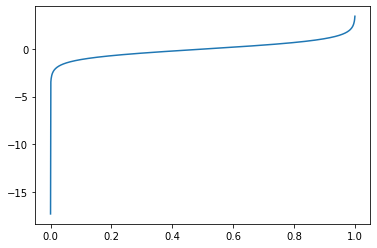

In [42]:
to_tanh_space(torch.Tensor(np.arange(-1,1,.001)).double(), [0., 1.])
pd.Series(to_tanh_space(torch.Tensor(np.arange(-1,1,.001)).double(), [0., 1.]).tolist(), 
          index=np.arange(-1,1,.001)).plot()

In [33]:
inputs = torch.Tensor(np.random.randint(0,2, (3,4)))
inputs

tensor([[0., 0., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])

In [34]:
to_tanh_space(inputs, [0., 1.])

tensor([[-inf, -inf, -inf, inf],
        [inf, inf, inf, -inf],
        [inf, inf, -inf, inf]])

In [35]:
torch.clamp(to_tanh_space(inputs, [0., 1.]), min=-1e4)

tensor([[-10., -10., -10.,  inf],
        [ inf,  inf,  inf, -10.],
        [ inf,  inf, -10.,  inf]])

In [45]:
from_tanh_space(torch.clamp(to_tanh_space(inputs, [0., 1.]), min=-1e4), [0., 1.])

tensor([[1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 1.]])

In [43]:
torch.clamp(inputs + from_tanh_space(pert_tanh*1000, [0., 1.]), max=1.0)

tensor([[1., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.]])

In [22]:
pert_tanh = torch.zeros((3,4))  # type: torch.FloatTensor
nn.init.normal_(pert_tanh, mean=0, std=1)
pert_tanh

tensor([[-1.9125,  1.7148, -0.6042,  0.3287],
        [ 0.8110,  0.7492, -0.4228, -0.1139],
        [-0.0307,  0.3254,  0.4284,  1.6197]])

In [26]:
from_tanh_space(pert_tanh*1e4, [0., 1.])

tensor([[0., 1., 0., 1.],
        [1., 1., 0., 0.],
        [0., 1., 1., 1.]])

In [48]:
torch.clamp(inputs + from_tanh_space(pert_tanh*1e4, [0., 1.]), max=1.0)

tensor([[1., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.]])

<AxesSubplot:>

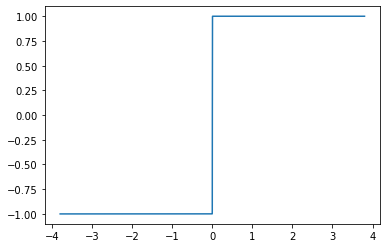

In [44]:
pd.Series(from_tanh_space(
    (to_tanh_space(torch.Tensor(np.arange(-1,1,.001)).double(), [-1., 1.])*1000), [-1., 1]).tolist(),
    index=to_tanh_space(torch.Tensor(np.arange(-1,1,.001)).double(), [-1., 1.]).tolist()).plot()

<AxesSubplot:>

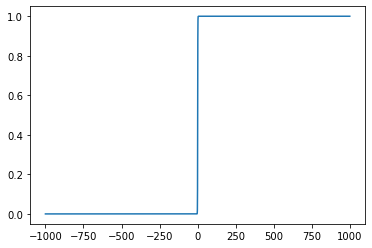

In [56]:
pd.Series(from_tanh_space(torch.Tensor(np.arange(-1000, 1000, 1)), box=[0,1]).tolist(),
    index=np.arange(-1000, 1000, 1)).plot()

In [13]:
from_tanh_space(to_tanh_space(torch.Tensor([0,.999]).double(), [-1., 1.]), [-1., 1])

tensor([0.0000, 0.9990], dtype=torch.float64)

In [ ]:
# def main():
#     # Training settings
#     parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#     parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                         help='input batch size for training (default: 64)')
#     parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                         help='input batch size for testing (default: 1000)')
#     parser.add_argument('--epochs', type=int, default=14, metavar='N',
#                         help='number of epochs to train (default: 14)')
#     parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
#                         help='learning rate (default: 1.0)')
#     parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
#                         help='Learning rate step gamma (default: 0.7)')
#     parser.add_argument('--no-cuda', action='store_true', default=False,
#                         help='disables CUDA training')
#     parser.add_argument('--dry-run', action='store_true', default=False,
#                         help='quickly check a single pass')
#     parser.add_argument('--seed', type=int, default=1, metavar='S',
#                         help='random seed (default: 1)')
#     parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                         help='how many batches to wait before logging training status')
#     parser.add_argument('--save-model', action='store_true', default=False,
#                         help='For Saving the current Model')
#     args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # load data (will need to be adapted as well)
    # 1) load A_test
    # 2) load labels
    # 3) Perform train-test-split
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])
#     dataset1 = datasets.MNIST('../data', train=True, download=True,
#                        transform=transform)
#     dataset2 = datasets.MNIST('../data', train=False,
#                        transform=transform)
    dataset = HindroidDataset(
        'data/out/all-apps/hindroid-train-half/A_test.npz', 
        'data/out/all-apps/hindroid-train-half/predictions.csv',
        'AAT'
    )
    train_loader = torch.utils.data.DataLoader(dataset,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

    model = HindroidSubstitute().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


# if __name__ == '__main__':
#     main()